In [1]:
!pip install xrft==0.4.0
!pip install numpy_groupies

In [2]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:46429")
client

<Client: 'tcp://127.0.0.1:46429' processes=8 threads=64, memory=235.96 GiB>

In [26]:
client.restart()

<Client: 'tcp://127.0.0.1:40437' processes=0 threads=0, memory=0 B>

In [3]:
import numpy as np
import xarray as xr
import pandas as pd
from scipy.ndimage import rotate
from xgcm.grid import Grid
import xrft
import s3fs
import matplotlib.colors as clr
import matplotlib.pyplot as plt
plt.rcParams['pcolor.shading'] = 'auto'
%matplotlib inline

In [4]:
import intake
import os
import gcsfs

gcs = gcsfs.GCSFileSystem(requester_pays=True)

SCRATCH = os.environ['SCRATCH_BUCKET']
SCRATCH

'gcs://meom-ige-scratch/roxyboy'

In [5]:
from validate_catalog import all_params
params_dict, cat = all_params()
params_dict.keys()

dict_keys(['GIGATL', 'HYCOM25', 'HYCOM50', 'eNATL60', 'FESOM', 'ORCA36', 'FIO-COM32'])

## User parameters

Our catalog implements `intake` parameters, which allow the user to choose which region, depth, and season subset they would like to open for a given catalog entry. Below is a record of the currently implemented catalog entries, their parameters, and allowable arguments for each parameter. Note that allowable arguments may differ between entries.

In [6]:
for entry in params_dict.keys():
    print(f"{entry} parameters and their allowable args are:")
    description = cat[entry].describe()
    params = description["user_parameters"]
    if len(params) != 0:
        for i in range(len(params)):
            print(f"""    {params[i]["name"]}: {params[i]["allowed"]}""")            
    else:
        print("    Not implemented.")
    print()

GIGATL parameters and their allowable args are:
    region: ['1', '2']
    datatype: ['surf', 'int']
    season: ['fma', 'aso']

HYCOM25 parameters and their allowable args are:
    region: ['1', '2', '3', '4', '5']
    datatype: ['surface_hourly']
    season: ['fma', 'aso']

HYCOM50 parameters and their allowable args are:
    region: ['1_GS', '2_GE', '3_MD']
    datatype: ['surf', 'int', 'int_wvel', 'grid']
    season: ['fma', 'aso', '']
    grid: ['grid', '']

eNATL60 parameters and their allowable args are:
    region: ['1', '2', '3']
    datatype: ['surface_hourly', 'interior_daily']
    season: ['fma', 'aso']

FESOM parameters and their allowable args are:
    datatype: ['surf', 'int']
    season: ['fma', 'aso']

ORCA36 parameters and their allowable args are:
    region: ['1', '2', '3', '4']
    datatype: ['surface_hourly', 'interior_daily', 'grid']
    season: ['fma', 'aso', '']
    grid: ['bathymetry', 'meshmask', '']

FIO-COM32 parameters and their allowable args are:
    reg

# Load data
## eNATL60

In [7]:
enatl01w = cat.eNATL60(region='1',datatype='surface_hourly', season='fma').to_dask()
enatl01s = cat.eNATL60(region='1',datatype='surface_hourly', season='aso').to_dask()
enatl01w

<xarray.Dataset>
Dimensions:        (time_counter: 2136, x: 611, y: 763)
Coordinates: (12/15)
    depth          (y, x) float32 dask.array<chunksize=(763, 611), meta=np.ndarray>
    e1f            (y, x) float64 dask.array<chunksize=(763, 611), meta=np.ndarray>
    e1t            (y, x) float64 dask.array<chunksize=(763, 611), meta=np.ndarray>
    e1u            (y, x) float64 dask.array<chunksize=(763, 611), meta=np.ndarray>
    e1v            (y, x) float64 dask.array<chunksize=(763, 611), meta=np.ndarray>
    e2f            (y, x) float64 dask.array<chunksize=(763, 611), meta=np.ndarray>
    ...             ...
    lat            (y, x) float32 dask.array<chunksize=(763, 611), meta=np.ndarray>
    lon            (y, x) float32 dask.array<chunksize=(763, 611), meta=np.ndarray>
    nav_lat        (y, x) float32 dask.array<chunksize=(763, 611), meta=np.ndarray>
    nav_lon        (y, x) float32 dask.array<chunksize=(763, 611), meta=np.ndarray>
    time_centered  (time_counter) datetime64[ns] dask.array<chunksize=(72,), meta=np.ndarray>
  * time_counter   (time_counter) datetime64[ns] 2010-02-01T00:30:00 ... 2010...
Dimensions without coordinates: x, y
Data variables: (12/13)
    fmask          (y, x) int8 dask.array<chunksize=(763, 611), meta=np.ndarray>
    qt_oce         (time_counter, y, x) float32 dask.array<chunksize=(72, 763, 611), meta=np.ndarray>
    somecrty       (time_counter, y, x) float32 dask.array<chunksize=(72, 763, 611), meta=np.ndarray>
    sometauy       (time_counter, y, x) float32 dask.array<chunksize=(72, 763, 611), meta=np.ndarray>
    sosaline       (time_counter, y, x) float32 dask.array<chunksize=(72, 763, 611), meta=np.ndarray>
    sossheig       (time_counter, y, x) float32 dask.array<chunksize=(72, 763, 611), meta=np.ndarray>
    ...             ...
    sowaflup       (time_counter, y, x) float32 dask.array<chunksize=(72, 763, 611), meta=np.ndarray>
    sozocrtx       (time_counter, y, x) float32 dask.array<chunksize=(72, 763, 611), meta=np.ndarray>
    sozotaux       (time_counter, y, x) float32 dask.array<chunksize=(72, 763, 611), meta=np.ndarray>
    tmask          (y, x) int8 dask.array<chunksize=(763, 611), meta=np.ndarray>
    umask          (y, x) int8 dask.array<chunksize=(763, 611), meta=np.ndarray>
    vmask          (y, x) int8 dask.array<chunksize=(763, 611), meta=np.ndarray>

## HYCOM50

In [8]:
hycom01w = cat.HYCOM50(region='1_GS', datatype='surf', season='fma', decode_times=False).to_dask()
hycom01s = cat.HYCOM50(region='1_GS', datatype='surf', season='aso', decode_times=False).to_dask()
hycom50_grid = cat.HYCOM50(region='1_GS', datatype='grid', grid='grid').to_dask()
hycom50_grid

<xarray.Dataset>
Dimensions:    (lat: 615, lon: 503)
Dimensions without coordinates: lat, lon
Data variables:
    depth      (lat, lon) float64 dask.array<chunksize=(615, 503), meta=np.ndarray>
    latitude   (lat) float64 dask.array<chunksize=(615,), meta=np.ndarray>
    longitude  (lon) float64 dask.array<chunksize=(503,), meta=np.ndarray>

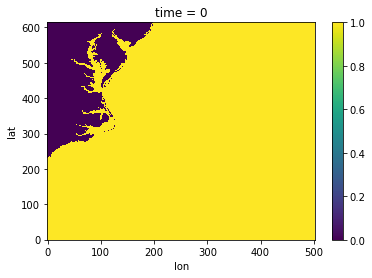

In [9]:
maskh = xr.DataArray(~np.ma.masked_invalid(hycom01w.ssh.isel(time=0)).mask, 
                     dims=hycom01w.ssh.isel(time=0).dims,
                     coords=hycom01w.ssh.isel(time=0).coords)
maskh.plot()

# HYCOM25

In [10]:
hycom25w = cat.HYCOM25(region='1', datatype='surface_hourly', season='fma', decode_times=False
                      ).to_dask()
hycom25s = cat.HYCOM25(region='1', datatype='surface_hourly', season='aso', decode_times=False
                      ).to_dask()
hycom25w

<xarray.Dataset>
Dimensions:     (X: 250, Y: 305, time: 2136)
Coordinates:
    lat         (Y, X) float32 dask.array<chunksize=(305, 250), meta=np.ndarray>
    lon         (Y, X) float32 dask.array<chunksize=(305, 250), meta=np.ndarray>
  * time        (time) int64 0 1 2 3 4 5 6 ... 2130 2131 2132 2133 2134 2135
Dimensions without coordinates: X, Y
Data variables:
    steric_ssh  (time, Y, X) float32 dask.array<chunksize=(356, 305, 250), meta=np.ndarray>
    total_ssh   (time, Y, X) float32 dask.array<chunksize=(356, 305, 250), meta=np.ndarray>
    u_0         (time, Y, X) float32 dask.array<chunksize=(356, 305, 250), meta=np.ndarray>
    u_15        (time, Y, X) float32 dask.array<chunksize=(356, 305, 250), meta=np.ndarray>
    v_0         (time, Y, X) float32 dask.array<chunksize=(356, 305, 250), meta=np.ndarray>
    v_15        (time, Y, X) float32 dask.array<chunksize=(356, 305, 250), meta=np.ndarray>

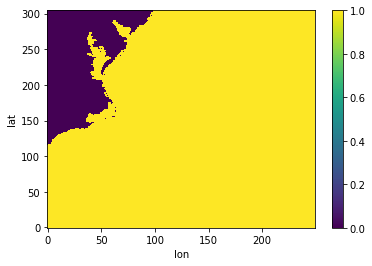

In [11]:
maskh_25 = xr.DataArray(~np.ma.masked_invalid(hycom25w.total_ssh.isel(time=0)).mask, 
                        dims=['lat','lon'])
maskh_25.plot()

In [12]:
# Functions to adapt croco outputs to xgcm
##########################################

def adjust_coords(ds):

    if 'nav_lon_u' not in ds.coords:
        ##########################
        # for regular CROCO files:
        ds = ds.set_coords([c for c in ds.variables if 'lon' in c or 'lat' in c ])

    else:
        ##########################
        # for XIOS files:
        
        ds = ds.rename({'time_counter': 'time'})
        
        ds = ds.reset_coords([c for c in ds.coords if 'nav' in c])

        # rename redundant dimensions
        _dims = (d for d in ['x_v', 'y_u', 'x_w', 'y_w'] if d in ds.dims)
        for d in _dims:
            ds = ds.rename({d: d[0]+'_rho'})

        # change axis names to xi,eta (instead of x,y)
        _dims = (d for d in ['x_u', 'x_rho'] if d in ds.dims)
        for d in _dims:
            ds = ds.rename({d: 'xi' + d[1:]}) 

        _dims = (d for d in ['y_v', 'y_rho'] if d in ds.dims)
        for d in _dims:
            ds = ds.rename({d: 'eta' + d[1:]}) 


        # change nav variables to coordinates        
        _coords = [d for d in [d for d in ds.data_vars.keys()] if "nav_" in d]
        ds = ds.set_coords(_coords) 

        # rename coordinates 
        eta_suff={}
        for c in ds.coords:
            new_c = c.replace('nav_lat','lat').replace('nav_lon','lon')
            ds = ds.rename({c:new_c})
            # reset names and units
            ds[new_c] = (ds[new_c].assign_attrs(units='deg', 
                                               standard_name=new_c,
                                               long_name=new_c)
                        )

    ##########################
    # For all types  
    if 'eta_psi' in ds.dims: ds = ds.rename({'eta_psi': 'eta_v'}) 
    if 'xi_psi' in ds.dims: ds = ds.rename({'xi_psi': 'xi_u'}) 
        

    ##########################
    # Create xgcm grid
    coords={'xi':{'center':'xi_rho', 'inner':'xi_u'}, 
            'eta':{'center':'eta_rho', 'inner':'eta_v'}, 
            's':{'center':'s_rho', 'outer':'s_w'}}

    ds.attrs['xgcm-Grid'] = Grid(ds, coords=coords, periodic=[])


    return ds

    
def add_grd(ds,grd):
    
    ##########################
    for variable in grd.data_vars.keys():
        #print(variable)
        ds[variable] = grd[variable]
        
    ds['mask_rho'] = ds.mask_rho.where(ds.mask_rho>0,np.nan)
    
    if 'lon_psi' not in ds.coords: 
        #ds['lon_psi'] = grd['lon_psi']
        #ds['lat_psi'] = grd['lat_psi']
        ds = ds.assign_coords({'lon_psi':grd['lon_psi'], 'lat_psi':grd['lat_psi']})

    return ds
 
    ########

gigatl01w = adjust_coords(cat.GIGATL(region='1', datatype='surf', season='fma').to_dask()
                         ).chunk({'eta_rho':100,'xi_rho':100,'eta_v':100,'xi_u':100})
gigatl01s = adjust_coords(cat.GIGATL(region='1', datatype='surf', season='aso').to_dask()
                         ).chunk({'eta_rho':100,'xi_rho':100,'eta_v':100,'xi_u':100})
gigatl01s

<xarray.Dataset>
Dimensions:     (eta_rho: 1489, eta_v: 1488, time: 2280, xi_rho: 1491, xi_u: 1490)
Coordinates:
    lat         (eta_rho, xi_rho) float32 dask.array<chunksize=(100, 100), meta=np.ndarray>
    lon         (eta_rho, xi_rho) float32 dask.array<chunksize=(100, 100), meta=np.ndarray>
Dimensions without coordinates: eta_rho, eta_v, time, xi_rho, xi_u
Data variables:
    angle       (eta_rho, xi_rho) float32 dask.array<chunksize=(100, 100), meta=np.ndarray>
    f           (eta_rho, xi_rho) float32 dask.array<chunksize=(100, 100), meta=np.ndarray>
    h           (eta_rho, xi_rho) float32 dask.array<chunksize=(100, 100), meta=np.ndarray>
    ocean_time  (time) float32 dask.array<chunksize=(24,), meta=np.ndarray>
    pm          (eta_rho, xi_rho) float32 dask.array<chunksize=(100, 100), meta=np.ndarray>
    pn          (eta_rho, xi_rho) float32 dask.array<chunksize=(100, 100), meta=np.ndarray>
    salt        (time, eta_rho, xi_rho) float32 dask.array<chunksize=(24, 100, 100), meta=np.ndarray>
    temp        (time, eta_rho, xi_rho) float32 dask.array<chunksize=(24, 100, 100), meta=np.ndarray>
    u           (time, eta_rho, xi_u) float32 dask.array<chunksize=(24, 100, 100), meta=np.ndarray>
    v           (time, eta_v, xi_rho) float32 dask.array<chunksize=(24, 100, 100), meta=np.ndarray>
    zeta        (time, eta_rho, xi_rho) float32 dask.array<chunksize=(24, 100, 100), meta=np.ndarray>
Attributes:
    xgcm-Grid:  <xgcm.Grid>\nxi Axis (not periodic, boundary=None):\n  * cent...

## FESOM

In [13]:
fesom01w = cat.FESOM(datatype='surf', season='fma').to_dask().chunk({'lat':100,'lon':100})
fesom01s = cat.FESOM(datatype='surf', season='aso').to_dask().chunk({'lat':100,'lon':100})
fesom01s

,Array,Chunk
Bytes,16.45 GiB,781.25 kiB
Shape,"(2208, 1000, 1000)","(10, 100, 100)"
Count,44422 Tasks,22100 Chunks
Type,float64,numpy.ndarray
,Array,Chunk
Bytes,16.45 GiB,781.25 kiB
Shape,"(2208, 1000, 1000)","(10, 100, 100)"
Count,44422 Tasks,22100 Chunks
Type,float64,numpy.ndarray
,Array,Chunk


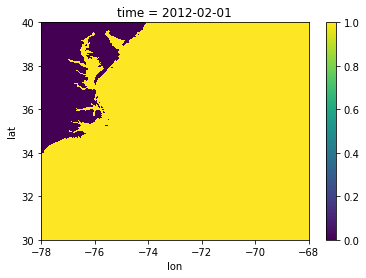

In [14]:
maskf = xr.DataArray(~np.ma.masked_invalid(fesom01w.ssh.isel(time=0)).mask, 
                     dims=fesom01w.ssh.isel(time=0).dims,
                     coords=fesom01w.ssh.isel(time=0).coords
                    )
maskf.plot()

## ORCA36

In [15]:
orca01w = cat.ORCA36(region='1',datatype='surface_hourly', season='fma').to_dask().isel(y=slice(None,450))
orca01s = cat.ORCA36(region='1',datatype='surface_hourly', season='aso').to_dask().isel(y=slice(None,450))
orca01_grid = cat.ORCA36(region='1',datatype='grid',grid='meshmask').to_dask().isel(time_counter=0,y=slice(None,450))
orca01_grid

<xarray.Dataset>
Dimensions:       (nav_lev: 75, x: 361, y: 450)
Coordinates:
  * nav_lev       (nav_lev) float32 0.5058 1.556 2.668 ... 5.698e+03 5.902e+03
    time_counter  float64 0.0
Dimensions without coordinates: x, y
Data variables: (12/50)
    e1f           (y, x) float64 dask.array<chunksize=(450, 361), meta=np.ndarray>
    e1t           (y, x) float64 dask.array<chunksize=(450, 361), meta=np.ndarray>
    e1u           (y, x) float64 dask.array<chunksize=(450, 361), meta=np.ndarray>
    e1v           (y, x) float64 dask.array<chunksize=(450, 361), meta=np.ndarray>
    e2f           (y, x) float64 dask.array<chunksize=(450, 361), meta=np.ndarray>
    e2t           (y, x) float64 dask.array<chunksize=(450, 361), meta=np.ndarray>
    ...            ...
    tmask         (nav_lev, y, x) int8 dask.array<chunksize=(75, 450, 361), meta=np.ndarray>
    tmaskutil     (y, x) int8 dask.array<chunksize=(450, 361), meta=np.ndarray>
    umask         (nav_lev, y, x) int8 dask.array<chunksize=(75, 450, 361), meta=np.ndarray>
    umaskutil     (y, x) int8 dask.array<chunksize=(450, 361), meta=np.ndarray>
    vmask         (nav_lev, y, x) int8 dask.array<chunksize=(75, 450, 361), meta=np.ndarray>
    vmaskutil     (y, x) int8 dask.array<chunksize=(450, 361), meta=np.ndarray>
Attributes:
    NCO:        "4.6.2"
    TimeStamp:  11/02/2021 04:31:39 -0000
    file_name:  mesh_mask.nc
    history:    Mon Jun 21 12:11:40 2021: ncks -O -F -d x,7526,7886 -d y,5884...

## LLC4320

In [16]:
import fsspec
url = "https://data.nas.nasa.gov/ecco/download_data.php?file=/eccodata/llc_4320/compressed/0000154224/Eta.0000154224.data.shrunk"
with fsspec.open(url, mode='rb') as fp:
    # test size works
    assert fp.size == 562551864
with fsspec.open(url, mode='rb') as fp:
    # test seek works
    fp.seek(2)

In [17]:
from xmitgcm import llcreader
model = llcreader.ECCOPortalLLC4320Model()
print(model.varnames)

['Eta', 'KPPhbl', 'oceFWflx', 'oceQnet', 'oceQsw', 'oceSflux', 'oceTAUX', 'oceTAUY', 'PhiBot', 'Salt', 'SIarea', 'SIheff', 'SIhsalt', 'SIhsnow', 'SIuice', 'SIvice', 'Theta', 'U', 'V', 'W']


In [18]:
istart = 497664
di = 144
iters = np.arange(istart,int(istart+(29+31+30)*24*di),di)
nl = 14
nlt = 1

Etaw = xr.DataArray(np.ones((len(iters),len(np.arange(9555,10198)[::nl]),
                             len(np.arange(15355,15845)[::nl])))*np.nan,
                    dims=['time','j','i'],
                    coords={'time':np.arange(len(iters))*3600}
                   )

dil = 10
for il in np.arange(len(iters))[::dil]:
    Etaw.isel(time=slice(il,il+dil))[:] = model.get_dataset(varnames=['Eta'], k_levels=[0], 
                                                            iters=list(iters[il:il+dil]),
                                                            type='latlon',
            #                                               grid_vars_to_coords=False
                                                           ).isel(j=list(np.arange(9555,10198)[::nl]),
                                                                  j_g=list(np.arange(9555,10198)[::nl]),
                                                                  i=list(np.arange(15355,15845)[::nl]),
                                                                  i_g=list(np.arange(15355,15845)[::nl]),
                                                                  k=0, k_l=0
                                                                 ).Eta.reset_coords(drop=True).load().data
    if il % 30 == 0:
        print(il, iters[il])
    
maskl = xr.DataArray(~np.ma.masked_invalid(Etaw.isel(time=0)).mask,
                     dims=['j','i']
                    ).chunk({'j':5,'i':5})
Etaw

0 497664
30 501984
60 506304
90 510624
120 514944
150 519264
180 523584
210 527904
240 532224
270 536544
300 540864
330 545184
360 549504
390 553824
420 558144
450 562464
480 566784
510 571104
540 575424
570 579744
600 584064
630 588384
660 592704
690 597024
720 601344
750 605664
780 609984
810 614304
840 618624
870 622944
900 627264
930 631584
960 635904
990 640224
1020 644544
1050 648864
1080 653184
1110 657504
1140 661824
1170 666144
1200 670464
1230 674784
1260 679104
1290 683424
1320 687744
1350 692064
1380 696384
1410 700704
1440 705024
1470 709344
1500 713664
1530 717984
1560 722304
1590 726624
1620 730944
1650 735264
1680 739584
1710 743904
1740 748224
1770 752544
1800 756864
1830 761184
1860 765504
1890 769824
1920 774144
1950 778464
1980 782784
2010 787104
2040 791424
2070 795744
2100 800064
2130 804384


<xarray.DataArray (time: 2160, j: 46, i: 35)>
array([[[ 0.21378186,  0.22804789,  0.22908743, ...,  0.20660047,
          0.19234464,  0.13650085],
        [ 0.2385596 ,  0.25107858,  0.21921442, ...,  0.22578709,
          0.23733565,  0.18499023],
        [ 0.26077956,  0.24569654,  0.21266218, ...,  0.28730804,
          0.29080838,  0.23958838],
        ...,
        [        nan,         nan,         nan, ..., -0.65253758,
         -0.62195474, -0.59248626],
        [        nan,         nan,         nan, ..., -0.66998971,
         -0.7003122 , -0.69940734],
        [        nan,         nan,         nan, ..., -0.6382221 ,
         -0.6689114 , -0.7024014 ]],

       [[ 0.32674345,  0.34447107,  0.34644777, ...,  0.28855446,
          0.27840632,  0.22346991],
        [ 0.35694703,  0.3640275 ,  0.32434011, ...,  0.31491727,
          0.32475355,  0.26838353],
        [ 0.38210326,  0.36482027,  0.32804146, ...,  0.37105846,
          0.36746344,  0.31872001],
...
        [        nan,         nan,         nan, ..., -0.38246602,
         -0.3967523 , -0.31188175],
        [        nan,         nan,         nan, ..., -0.39452887,
         -0.3293435 , -0.35199219],
        [        nan,         nan,         nan, ..., -0.35958931,
         -0.33054066, -0.36943662]],

       [[ 0.36339486,  0.38505822,  0.38969317, ...,  0.31932813,
          0.29338759,  0.23698252],
        [ 0.34303859,  0.35387936,  0.39658642, ...,  0.31793895,
          0.29838866,  0.26205352],
        [ 0.31903148,  0.34813383,  0.37566775, ...,  0.30404398,
          0.31813926,  0.28508067],
        ...,
        [        nan,         nan,         nan, ..., -0.53143412,
         -0.54539233, -0.46176618],
        [        nan,         nan,         nan, ..., -0.55784112,
         -0.49299625, -0.53287745],
        [        nan,         nan,         nan, ..., -0.51394433,
         -0.48837298, -0.53973413]]])
Coordinates:
  * time     (time) int64 0 3600 7200 10800 ... 7761600 7765200 7768800 7772400
Dimensions without coordinates: j, i

In [23]:
istart = 1126656
di = 144
iters = np.arange(istart,int(istart+(31+30+31)*24*di),di)

Etas = xr.DataArray(np.ones((len(iters),len(np.arange(9555,10198)[::nl]),
                             len(np.arange(15355,15845)[::nl])))*np.nan,
                    dims=['time','j','i'],
                    coords={'time':np.arange(len(iters))*3600}
                   )

dil = 10
for il in np.arange(len(iters))[::dil]:
    Etas.isel(time=slice(il,il+dil))[:] = model.get_dataset(varnames=['Eta'], k_levels=[0], 
                                                            iters=list(iters[il:il+dil]),
                                                            type='latlon',
            #                                               grid_vars_to_coords=False
                                                           ).isel(j=list(np.arange(9555,10198)[::nl]),
                                                                  j_g=list(np.arange(9555,10198)[::nl]),
                                                                  i=list(np.arange(15355,15845)[::nl]),
                                                                  i_g=list(np.arange(15355,15845)[::nl]),
                                                                  k=0, k_l=0
                                                                 ).Eta.reset_coords(drop=True).load().data
    if il % 30 == 0:
        print(il, iters[il])
    
Etas

0 1126656
30 1130976
60 1135296
90 1139616
120 1143936
150 1148256
180 1152576
210 1156896
240 1161216
270 1165536
300 1169856
330 1174176
360 1178496
390 1182816
420 1187136
450 1191456
480 1195776
510 1200096
540 1204416
570 1208736
600 1213056
630 1217376
660 1221696
690 1226016
720 1230336
750 1234656
780 1238976
810 1243296
840 1247616
870 1251936
900 1256256
930 1260576
960 1264896
990 1269216
1020 1273536
1050 1277856
1080 1282176
1110 1286496
1140 1290816
1170 1295136
1200 1299456
1230 1303776
1260 1308096
1290 1312416
1320 1316736
1350 1321056
1380 1325376
1410 1329696
1440 1334016
1470 1338336
1500 1342656
1530 1346976
1560 1351296
1590 1355616
1620 1359936
1650 1364256
1680 1368576
1710 1372896
1740 1377216
1770 1381536
1800 1385856
1830 1390176
1860 1394496
1890 1398816
1920 1403136
1950 1407456
1980 1411776
2010 1416096
2040 1420416
2070 1424736
2100 1429056
2130 1433376
2160 1437696
2190 1442016


<xarray.DataArray (time: 2208, j: 46, i: 35)>
array([[[ 1.42015541,  1.39407647,  1.36642396, ...,  1.07050252,
          1.10743105,  1.14852428],
        [ 1.37409663,  1.34506679,  1.29779315, ...,  1.12520707,
          1.18940055,  1.20491195],
        [ 1.34222972,  1.27573836,  1.2923758 , ...,  1.16753542,
          1.20254302,  1.23202968],
        ...,
        [        nan,         nan,         nan, ...,  0.53885686,
          0.51630151,  0.53912276],
        [        nan,         nan,         nan, ...,  0.51953214,
          0.49164641,  0.57173681],
        [        nan,         nan,         nan, ...,  0.5104847 ,
          0.47646058,  0.54957038]],

       [[ 1.07882679,  1.06061387,  1.04344702, ...,  0.81022054,
          0.84275234,  0.89820355],
        [ 1.04500329,  0.99225205,  0.97163248, ...,  0.85831577,
          0.90778571,  0.93513763],
        [ 0.99207819,  0.9270708 ,  0.96303141, ...,  0.90481609,
          0.93499464,  0.98005617],
...
        [        nan,         nan,         nan, ...,  0.27092412,
          0.29336363,  0.27459273],
        [        nan,         nan,         nan, ...,  0.22438386,
          0.27011496,  0.26715225],
        [        nan,         nan,         nan, ...,  0.26276606,
          0.27899361,  0.29983518]],

       [[ 1.38788223,  1.35514522,  1.35439718, ...,  1.37182546,
          1.36397099,  1.33431566],
        [ 1.42468715,  1.3954972 ,  1.35753381, ...,  1.35153508,
          1.33322167,  1.29475391],
        [ 1.41463196,  1.40460312,  1.36617064, ...,  1.30994034,
          1.28026056,  1.27224553],
        ...,
        [        nan,         nan,         nan, ...,  0.47046003,
          0.47285715,  0.45620134],
        [        nan,         nan,         nan, ...,  0.47335079,
          0.47625089,  0.49177679],
        [        nan,         nan,         nan, ...,  0.43730241,
          0.48221135,  0.51985776]]])
Coordinates:
  * time     (time) int64 0 3600 7200 10800 ... 7934400 7938000 7941600 7945200
Dimensions without coordinates: j, i

# FIO-COM32

In [18]:
fio01w = cat['FIO-COM32'](region='1',datatype='surface_hourly', season='fma'
                      ).to_dask()
fio01s = cat['FIO-COM32'](region='1',datatype='surface_hourly', season='aso'
                      ).to_dask()

# Assume local Cartesian plane
## Sea-surface height

In [19]:
enatl01s_H = xr.DataArray(enatl01s.sossheig.data, dims=['time','y','x'],
                          coords={'time':np.arange(len(enatl01s.time_counter))*3600}
                         ).chunk({'time':-1})
enatl01w_H = xr.DataArray(enatl01w.sossheig.data, dims=['time','y','x'],
                          coords={'time':np.arange(len(enatl01w.time_counter))*3600}
                         ).chunk({'time':-1})
enatl01s_H

<xarray.DataArray 'open_dataset-25bc35c91fa851fd4902dda3e8770671sossheig-968615a246227df15547c890365b0a10' (time: 2208, y: 763, x: 611)>
dask.array<rechunk-merge, shape=(2208, 763, 611), dtype=float32, chunksize=(2208, 763, 611), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) int64 0 3600 7200 10800 ... 7934400 7938000 7941600 7945200
Dimensions without coordinates: y, x

In [21]:
hycom01w_H = xr.DataArray(hycom01w.ssh.data*1e-2, dims=['time','lat','lon'],
                          coords={'time':np.arange(len(hycom01w.time))*3600}
                         ).chunk({'time':-1})
hycom01s_H = xr.DataArray(hycom01s.ssh.data*1e-2, dims=['time','lat','lon'],
                          coords={'time':np.arange(len(hycom01s.time))*3600}
                         ).chunk({'time':-1})

hycom01w_H

<xarray.DataArray 'mul-641daedcc9c02d5485273099e442a261' (time: 2160, lat: 615, lon: 503)>
dask.array<rechunk-merge, shape=(2160, 615, 503), dtype=float32, chunksize=(2160, 615, 503), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) int64 0 3600 7200 10800 ... 7761600 7765200 7768800 7772400
Dimensions without coordinates: lat, lon

In [15]:
n25 = 3
hycom25w_H = xr.DataArray(hycom25w.total_ssh[:,::n25,::n25].data, dims=['time','lat','lon'],
                          coords={'time':np.arange(len(hycom25w.time))*3600}
                         ).chunk({'time':-1,'lat':10,'lon':10})
hycom25s_H = xr.DataArray(hycom25s.total_ssh[:,::n25,::n25].data, dims=['time','lat','lon'],
                          coords={'time':np.arange(len(hycom25s.time))*3600}
                         ).chunk({'time':-1,'lat':10,'lon':10})

hycom25w_H

<xarray.DataArray 'getitem-26c128df9e9969832ff5677c0e58d8dc' (time: 2136, lat: 102, lon: 84)>
dask.array<rechunk-merge, shape=(2136, 102, 84), dtype=float32, chunksize=(2136, 10, 10), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) int64 0 3600 7200 10800 ... 7675200 7678800 7682400 7686000
Dimensions without coordinates: lat, lon

In [34]:
gridg = gigatl01w.attrs["xgcm-Grid"]

gigatl01w_H = xr.DataArray(gigatl01w.zeta.isel(eta_rho=slice(None,1300)).data, dims=['time','eta_rho','xi_rho'],
                           coords={'time':np.arange(len(gigatl01w.time))*3600}
                          ).chunk({'time':-1})
gigatl01s_H = xr.DataArray(gigatl01s.zeta.isel(eta_rho=slice(None,1300)).data, dims=['time','eta_rho','xi_rho'],
                           coords={'time':np.arange(len(gigatl01s.time))*3600}
                          ).chunk({'time':-1})
gigatl01w_H

,Array,Chunk
Bytes,16.46 GiB,86.98 MiB
Shape,"(2280, 1300, 1491)","(2280, 100, 100)"
Count,61566 Tasks,195 Chunks
Type,float32,numpy.ndarray


In [35]:
fesom01s_H = xr.DataArray(fesom01s.ssh.data, dims=['time','lat','lon'],
                          coords={'time':np.arange(len(fesom01s.time))*3600}
                         ).chunk({'time':-1})
fesom01w_H = xr.DataArray(fesom01w.ssh.data, dims=['time','lat','lon'],
                          coords={'time':np.arange(len(fesom01w.time))*3600}
                         ).chunk({'time':-1})

fesom01s_H

<xarray.DataArray 'rechunk-merge-7faa0ea0adde11a42e1db30673e401b2' (time: 2208, lat: 1000, lon: 1000)>
dask.array<rechunk-merge, shape=(2208, 1000, 1000), dtype=float64, chunksize=(2208, 100, 100), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) int64 0 3600 7200 10800 ... 7934400 7938000 7941600 7945200
Dimensions without coordinates: lat, lon

In [24]:
orca01s_H = xr.DataArray(orca01s.sossheig.data, 
                         dims=['time','y','x'],
                         coords={'time':np.arange(len(orca01s.time_counter))*3600}
                        ).chunk({'time':-1})
orca01w_H = xr.DataArray(orca01w.sossheig.data, 
                         dims=['time','y','x'],
                         coords={'time':np.arange(len(orca01w.time_counter))*3600}
                        ).chunk({'time':-1})
orca01s_H

<xarray.DataArray 'getitem-0e35bfe3402abd0e3079ec082e08a85f' (time: 2208, y: 450, x: 361)>
dask.array<rechunk-merge, shape=(2208, 450, 361), dtype=float32, chunksize=(2208, 450, 361), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) int64 0 3600 7200 10800 ... 7934400 7938000 7941600 7945200
Dimensions without coordinates: y, x

In [10]:
fio01s_H = xr.DataArray(fio01s.eta_t.data, dims=['time','yt_ocean','xt_ocean'],
                        coords={'time':np.arange(len(fio01s.time))*3600}
                       ).chunk({'time':-1})
fio01w_H = xr.DataArray(fio01w.eta_t.data, dims=['time','yt_ocean','xt_ocean'],
                        coords={'time':np.arange(len(fio01w.time))*3600}
                       ).chunk({'time':-1})
fio01s_H

<xarray.DataArray 'open_dataset-fe0885fe81a7e8b7c4309191105077baeta_t-c4a6160939ff8d66c9d626a58c58f330' (time: 2208, yt_ocean: 320, xt_ocean: 320)>
dask.array<rechunk-merge, shape=(2208, 320, 320), dtype=float32, chunksize=(2208, 320, 320), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) int64 0 3600 7200 10800 ... 7934400 7938000 7941600 7945200
Dimensions without coordinates: yt_ocean, xt_ocean

In [39]:
ne = 15
Fenatlw_H = xrft.power_spectrum(enatl01w_H[:,::ne,::ne].fillna(0.),
                                dim=['time'], window='hann', detrend='linear', true_phase=True, true_amplitude=True,
                                window_correction=True
                               )
Fenatlw_H = Fenatlw_H.isel(freq_time=slice(len(Fenatlw_H.freq_time)//2,None)) * 2

Fenatls_H = xrft.power_spectrum(enatl01s_H[:,::ne,::ne].fillna(0.),
                                dim=['time'], window='hann', detrend='linear', true_phase=True, true_amplitude=True,
                                window_correction=True
                               )
Fenatls_H = Fenatls_H.isel(freq_time=slice(len(Fenatls_H.freq_time)//2,None)) * 2

Fenatls_H

<xarray.DataArray (freq_time: 732, y: 51, x: 41)>
dask.array<mul, shape=(732, 51, 41), dtype=float64, chunksize=(732, 51, 41), chunktype=numpy.ndarray>
Coordinates:
  * freq_time  (freq_time) float64 0.0 1.897e-07 ... 0.0001385 0.0001387
Dimensions without coordinates: y, x

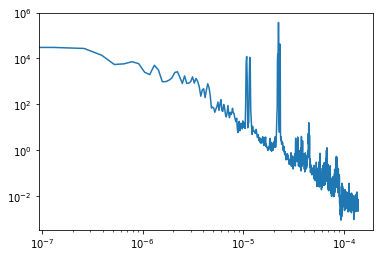

In [42]:
plt.loglog(Fenatlw_H.freq_time, Fenatlw_H.where(enatl01w.tmask[::ne,::ne]!=0.).mean(['y','x'],skipna=True))

In [43]:
tmp_path = f'{SCRATCH}/region01/eNATL60/'+f'SSH_omega_fma.zarr'
store_tmp = gcs.get_mapper(tmp_path)
Fenatlw_H.where(enatl01w.tmask[::ne,::ne]!=0.).mean(['y','x'],skipna=True).to_dataset(name='spectra').to_zarr(store_tmp, mode='w')
print(tmp_path)

tmp_path = f'{SCRATCH}/region01/eNATL60/'+f'SSH_omega_aso.zarr'
store_tmp = gcs.get_mapper(tmp_path)
Fenatls_H.where(enatl01s.tmask[::ne,::ne]!=0.).mean(['y','x'],skipna=True).to_dataset(name='spectra').to_zarr(store_tmp, mode='w')
print(tmp_path)

gcs://meom-ige-scratch/roxyboy/region01/eNATL60/SSH_omega_fma.zarr
gcs://meom-ige-scratch/roxyboy/region01/eNATL60/SSH_omega_aso.zarr


In [16]:
Fenatlw_H = xr.open_zarr(gcs.get_mapper(f"gcs://meom-ige-scratch/roxyboy/region01/eNATL60/SSH_omega_fma.zarr")).spectra

Fenatls_H = xr.open_zarr(gcs.get_mapper(f"gcs://meom-ige-scratch/roxyboy/region01/eNATL60/SSH_omega_aso.zarr")).spectra

Fenatlw_H

<xarray.DataArray 'spectra' (freq_time: 1068)>
dask.array<open_dataset-4ed2b16116ccf5fe25089cf88a946515spectra, shape=(1068,), dtype=float64, chunksize=(1068,), chunktype=numpy.ndarray>
Coordinates:
  * freq_time  (freq_time) float64 0.0 1.3e-07 2.601e-07 ... 0.0001386 0.0001388

In [44]:
nh = 12
Fhycomw_H = xrft.power_spectrum(hycom01w_H[:,::nh,::nh].fillna(0.), 
                                dim=['time'], window='hann', detrend='linear', true_phase=True, true_amplitude=True
                               )
Fhycomw_H = Fhycomw_H.isel(freq_time=slice(len(Fhycomw_H.freq_time)//2,None)) * 2

Fhycoms_H = xrft.power_spectrum(hycom01s_H[:,::nh,::nh].fillna(0.), 
                                dim=['time'], window='hann', detrend='linear', true_phase=True, true_amplitude=True
                               )
Fhycoms_H = Fhycoms_H.isel(freq_time=slice(len(Fhycoms_H.freq_time)//2,None)) * 2

Fhycoms_H

<xarray.DataArray 'rechunk-merge-73d303f8557582c6371369bb7a36caa3' (freq_time: 1104, lat: 52, lon: 42)>
dask.array<mul, shape=(1104, 52, 42), dtype=float64, chunksize=(1104, 52, 42), chunktype=numpy.ndarray>
Coordinates:
  * freq_time  (freq_time) float64 0.0 1.258e-07 ... 0.0001386 0.0001388
Dimensions without coordinates: lat, lon

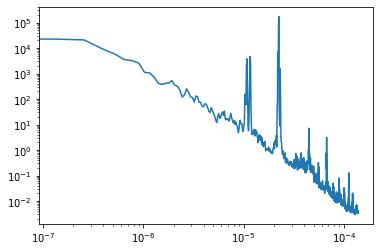

In [45]:
plt.loglog(Fhycomw_H.freq_time, Fhycomw_H.where(maskh[::nh,::nh]).mean(['lat','lon'],skipna=True))

In [21]:
tmp_path = f'{SCRATCH}/region01/HYCOM50/'+f'SSH_omega_fma.zarr'
store_tmp = gcs.get_mapper(tmp_path)
Fhycomw_H.where(maskh[::nh,::nh]).mean(['lat','lon'],skipna=True).to_dataset(name='spectra').to_zarr(store_tmp, mode='w')
print(tmp_path)

tmp_path = f'{SCRATCH}/region01/HYCOM50/'+f'SSH_omega_aso.zarr'
store_tmp = gcs.get_mapper(tmp_path)
Fhycoms_H.where(maskh[::nh,::nh]).mean(['lat','lon'],skipna=True).to_dataset(name='spectra').to_zarr(store_tmp, mode='w')
print(tmp_path)

NameError: name 'Fhycomw_H' is not defined

In [17]:
Fhycomw_H = xr.open_zarr(gcs.get_mapper(f"gcs://meom-ige-scratch/roxyboy/region01/HYCOM50/SSH_omega_fma.zarr")).spectra

Fhycoms_H = xr.open_zarr(gcs.get_mapper(f"gcs://meom-ige-scratch/roxyboy/region01/HYCOM50/SSH_omega_aso.zarr")).spectra

Fhycomw_H

/srv/conda/envs/notebook/lib/python3.8/site-packages/xarray/coding/times.py:527: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/srv/conda/envs/notebook/lib/python3.8/site-packages/xarray/core/indexing.py:572: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)


<xarray.DataArray 'spectra' (freq_time: 1080)>
dask.array<open_dataset-973f5cb1c9d8aa5ed8617d051ea45e54spectra, shape=(1080,), dtype=float64, chunksize=(1080,), chunktype=numpy.ndarray>
Coordinates:
  * freq_time  (freq_time) float64 0.0 1.286e-07 ... 0.0001386 0.0001388
    time       object ...

In [22]:
Fhycom25w_H = xrft.power_spectrum(hycom25w_H.fillna(0.), 
                                  dim=['time'], window='hann', detrend='linear', 
                                  true_phase=True, true_amplitude=True
                                 )
Fhycom25w_H = Fhycom25w_H.isel(freq_time=slice(len(Fhycom25w_H.freq_time)//2,None)) * 2

Fhycom25s_H = xrft.power_spectrum(hycom25s_H.fillna(0.), 
                                  dim=['time'], window='hann', detrend='linear', 
                                  true_phase=True, true_amplitude=True
                                 )
Fhycom25s_H = Fhycom25s_H.isel(freq_time=slice(len(Fhycom25s_H.freq_time)//2,None)) * 2

Fhycom25s_H

<xarray.DataArray 'rechunk-merge-fdf0e8a2dc41ad5a3cd82f631d1d357b' (freq_time: 1104, lat: 102, lon: 84)>
dask.array<mul, shape=(1104, 102, 84), dtype=float64, chunksize=(1104, 10, 10), chunktype=numpy.ndarray>
Coordinates:
  * freq_time  (freq_time) float64 0.0 1.258e-07 ... 0.0001386 0.0001388
Dimensions without coordinates: lat, lon

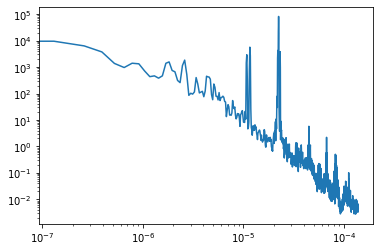

In [23]:
plt.loglog(Fhycom25w_H.freq_time, Fhycom25w_H.where(maskh_25[::n25,::n25]).mean(['lat','lon'],skipna=True))

In [24]:
tmp_path = f'{SCRATCH}/region01/HYCOM25/'+f'SSH_omega_fma.zarr'
store_tmp = gcs.get_mapper(tmp_path)
Fhycom25w_H.where(maskh_25[::n25,::n25]).mean(['lat','lon'],skipna=True).to_dataset(name='spectra').to_zarr(store_tmp, mode='w')
print(tmp_path)

tmp_path = f'{SCRATCH}/region01/HYCOM25/'+f'SSH_omega_aso.zarr'
store_tmp = gcs.get_mapper(tmp_path)
Fhycom25s_H.where(maskh_25[::n25,::n25]).mean(['lat','lon'],skipna=True).to_dataset(name='spectra').to_zarr(store_tmp, mode='w')
print(tmp_path)

gcs://meom-ige-scratch/roxyboy/region01/HYCOM25/SSH_omega_fma.zarr
gcs://meom-ige-scratch/roxyboy/region01/HYCOM25/SSH_omega_aso.zarr


In [18]:
Fhycom25w_H = xr.open_zarr(gcs.get_mapper(f"gcs://meom-ige-scratch/roxyboy/region01/HYCOM25/SSH_omega_fma.zarr")).spectra

Fhycom25s_H = xr.open_zarr(gcs.get_mapper(f"gcs://meom-ige-scratch/roxyboy/region01/HYCOM25/SSH_omega_aso.zarr")).spectra

Fhycom25w_H

<xarray.DataArray 'spectra' (freq_time: 1068)>
dask.array<open_dataset-a55bd50d309858396ce47aef24c31ad4spectra, shape=(1068,), dtype=float64, chunksize=(1068,), chunktype=numpy.ndarray>
Coordinates:
  * freq_time  (freq_time) float64 0.0 1.3e-07 2.601e-07 ... 0.0001386 0.0001388

In [39]:
ng = 20

Fgigatlw_H = xrft.power_spectrum(gigatl01s_H.isel(eta_rho=slice(None,1300))[:,::ng,::ng].chunk({'eta_rho':15,'xi_rho':15}).fillna(0.),
                                 dim=['time'], window='hann', detrend='linear', true_phase=True, true_amplitude=True,
                                 window_correction=True
                                )
Fgigatlw_H = Fgigatlw_H.isel(freq_time=slice(len(Fgigatlw_H.freq_time)//2,None)) * 2
Fgigatlw_H

<xarray.DataArray (freq_time: 1140, eta_rho: 65, xi_rho: 75)>
dask.array<mul, shape=(1140, 65, 75), dtype=float64, chunksize=(1140, 15, 15), chunktype=numpy.ndarray>
Coordinates:
  * freq_time  (freq_time) float64 0.0 1.218e-07 ... 0.0001386 0.0001388
Dimensions without coordinates: eta_rho, xi_rho

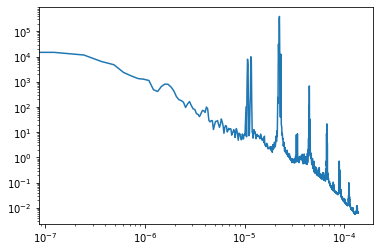

In [40]:
plt.loglog(Fgigatlw_H.freq_time, Fgigatlw_H.where(gigatl01w.temp.isel(time=0,eta_rho=slice(None,1300)
                                                                     )[::ng,::ng]!=0.
                                                 ).mean(['eta_rho','xi_rho'], skipna=True))

In [42]:
tmp_path = f'{SCRATCH}/region01/GIGATL/'+f'SSH_omega_fma.zarr'
store_tmp = gcs.get_mapper(tmp_path)
Fgigatlw_H.where(gigatl01w.temp.isel(time=0,eta_rho=slice(None,1300))[::ng,::ng]!=0.
                ).mean(['eta_rho','xi_rho'], skipna=True
                      ).to_dataset(name='spectra').to_zarr(store_tmp, mode='w')
print(tmp_path)

gcs://meom-ige-scratch/roxyboy/region01/GIGATL/SSH_omega_fma.zarr


In [43]:
Fgigatls_H = xrft.power_spectrum(gigatl01s_H[:,::ng,::ng].fillna(0.),
                                 dim=['time'], window='hann', detrend='linear', true_phase=True, true_amplitude=True,
                                 window_correction=True
             )
Fgigatls_H = Fgigatls_H.isel(freq_time=slice(len(Fgigatls_H.freq_time)//2,None)) * 2
Fgigatls_H

,Array,Chunk
Bytes,42.40 MiB,222.66 kiB
Shape,"(1140, 65, 75)","(1140, 5, 5)"
Count,65670 Tasks,195 Chunks
Type,float64,numpy.ndarray


In [44]:
tmp_path = f'{SCRATCH}/region01/GIGATL/'+f'SSH_omega_aso.zarr'
store_tmp = gcs.get_mapper(tmp_path)
Fgigatls_H.where(gigatl01s.temp.isel(time=0,eta_rho=slice(None,1300))[::ng,::ng]!=0.
                ).mean(['eta_rho','xi_rho'], skipna=True
                      ).to_dataset(name='spectra').to_zarr(store_tmp, mode='w')
print(tmp_path)

gcs://meom-ige-scratch/roxyboy/region01/GIGATL/SSH_omega_aso.zarr


In [19]:
Fgigaw_H = xr.open_zarr(gcs.get_mapper(f"gcs://meom-ige-scratch/roxyboy/region01/GIGATL/SSH_omega_fma.zarr")).spectra

Fgigas_H = xr.open_zarr(gcs.get_mapper(f"gcs://meom-ige-scratch/roxyboy/region01/GIGATL/SSH_omega_aso.zarr")).spectra

Fgigaw_H

<xarray.DataArray 'spectra' (freq_time: 1140)>
dask.array<open_dataset-78bf633168fec3b7c22ea89c9b0f028cspectra, shape=(1140,), dtype=float64, chunksize=(1140,), chunktype=numpy.ndarray>
Coordinates:
  * freq_time  (freq_time) float64 0.0 1.218e-07 ... 0.0001386 0.0001388

In [36]:
nf = 16
Ffesomw_H = xrft.power_spectrum(fesom01w_H[:,::nf,::nf].chunk({'lat':9,'lon':9}).fillna(0.),
                                dim=['time'], window='hann', detrend='linear', true_phase=True, true_amplitude=True,
                                window_correction=True
            )
Ffesomw_H = Ffesomw_H.isel(freq_time=slice(len(Ffesomw_H.freq_time)//2,None)) * 2

Ffesoms_H = xrft.power_spectrum(fesom01s_H[:,::nf,::nf].chunk({'lat':9,'lon':9}).fillna(0.),
                                dim=['time'], window='hann', detrend='linear', true_phase=True, true_amplitude=True,
                                window_correction=True
            )
Ffesoms_H = Ffesoms_H.isel(freq_time=slice(len(Ffesoms_H.freq_time)//2,None)) * 2

Ffesoms_H

<xarray.DataArray (freq_time: 1104, lat: 63, lon: 63)>
dask.array<mul, shape=(1104, 63, 63), dtype=float64, chunksize=(1104, 9, 9), chunktype=numpy.ndarray>
Coordinates:
  * freq_time  (freq_time) float64 0.0 1.258e-07 ... 0.0001386 0.0001388
Dimensions without coordinates: lat, lon

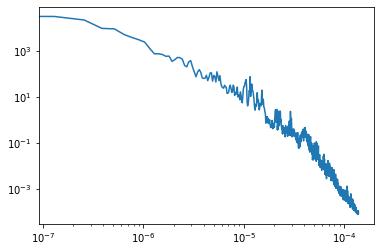

In [37]:
plt.loglog(Ffesomw_H.freq_time, Ffesomw_H.where(maskf[::nf,::nf]).mean(['lat','lon'], skipna=True))

In [38]:
tmp_path = f'{SCRATCH}/region01/FESOM/'+f'SSH_omega_fma.zarr'
store_tmp = gcs.get_mapper(tmp_path)
Ffesomw_H.where(maskf[::nf,::nf]).mean(['lat','lon'], skipna=True).to_dataset(name='spectra').to_zarr(store_tmp, mode='w')
print(tmp_path)

tmp_path = f'{SCRATCH}/region01/FESOM/'+f'SSH_omega_aso.zarr'
store_tmp = gcs.get_mapper(tmp_path)
Ffesoms_H.where(maskf[::nf,::nf]).mean(['lat','lon'], skipna=True).to_dataset(name='spectra').to_zarr(store_tmp, mode='w')
print(tmp_path)

gcs://meom-ige-scratch/roxyboy/region01/FESOM/SSH_omega_fma.zarr
gcs://meom-ige-scratch/roxyboy/region01/FESOM/SSH_omega_aso.zarr


In [20]:
Ffesomw_H = xr.open_zarr(gcs.get_mapper(f"gcs://meom-ige-scratch/roxyboy/region01/FESOM/SSH_omega_fma.zarr")).spectra

Ffesoms_H = xr.open_zarr(gcs.get_mapper(f"gcs://meom-ige-scratch/roxyboy/region01/FESOM/SSH_omega_aso.zarr")).spectra

Ffesomw_H

<xarray.DataArray 'spectra' (freq_time: 1080)>
dask.array<open_dataset-aa0851a618d1e4297097a7ec726a0b4cspectra, shape=(1080,), dtype=float64, chunksize=(1080,), chunktype=numpy.ndarray>
Coordinates:
  * freq_time  (freq_time) float64 0.0 1.286e-07 ... 0.0001386 0.0001388
    time       datetime64[ns] ...

In [25]:
no = 10

Forcaw_H = xrft.power_spectrum(orca01w_H[:,::no,::no].fillna(0.),
                               dim=['time'], window='hann', detrend='linear', true_phase=True, true_amplitude=True,
                               window_correction=True
                   )
Forcaw_H = Forcaw_H.isel(freq_time=slice(len(Forcaw_H.freq_time)//2,None)) * 2

Forcas_H = xrft.power_spectrum(orca01s_H[:,::no,::no].fillna(0.), 
                               dim=['time'], window='hann', detrend='linear', true_phase=True, true_amplitude=True,
                               window_correction=True
                   )
Forcas_H = Forcas_H.isel(freq_time=slice(len(Forcas_H.freq_time)//2,None)) * 2

Forcas_H

<xarray.DataArray (freq_time: 1104, y: 45, x: 37)>
dask.array<mul, shape=(1104, 45, 37), dtype=float64, chunksize=(1104, 45, 37), chunktype=numpy.ndarray>
Coordinates:
  * freq_time  (freq_time) float64 0.0 1.258e-07 ... 0.0001386 0.0001388
Dimensions without coordinates: y, x

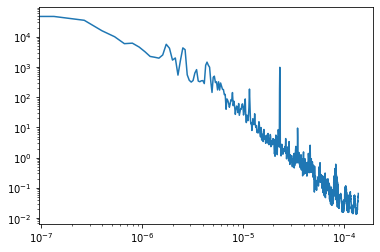

In [26]:
plt.loglog(Forcaw_H.freq_time, Forcaw_H.where(orca01_grid.tmask[0,::no,::no]).mean(['y','x'],skipna=True))

In [27]:
tmp_path = f'{SCRATCH}/region01/ORCA36/'+f'SSH_omega_fma.zarr'
store_tmp = gcs.get_mapper(tmp_path)
Forcaw_H.where(orca01_grid.tmask[0,::no,::no]).mean(['y','x'],skipna=True).to_dataset(name='spectra').to_zarr(store_tmp, mode='w')
print(tmp_path)

tmp_path = f'{SCRATCH}/region01/ORCA36/'+f'SSH_omega_aso.zarr'
store_tmp = gcs.get_mapper(tmp_path)
Forcas_H.where(orca01_grid.tmask[0,::no,::no]).mean(['y','x'],skipna=True).to_dataset(name='spectra').to_zarr(store_tmp, mode='w')
print(tmp_path)

gcs://meom-ige-scratch/roxyboy/region01/ORCA36/SSH_omega_fma.zarr
gcs://meom-ige-scratch/roxyboy/region01/ORCA36/SSH_omega_aso.zarr


In [21]:
Forcaw_H = xr.open_zarr(gcs.get_mapper(f"gcs://meom-ige-scratch/roxyboy/region01/ORCA36/SSH_omega_fma.zarr")).spectra

Forcas_H = xr.open_zarr(gcs.get_mapper(f"gcs://meom-ige-scratch/roxyboy/region01/ORCA36/SSH_omega_aso.zarr")).spectra

Forcaw_H

<xarray.DataArray 'spectra' (freq_time: 1045)>
dask.array<open_dataset-632a456ec9baba7b5d83efd9a527e6afspectra, shape=(1045,), dtype=float64, chunksize=(1045,), chunktype=numpy.ndarray>
Coordinates:
  * freq_time     (freq_time) float64 0.0 1.329e-07 ... 0.0001386 0.0001388
    nav_lev       float32 ...
    time_counter  float64 ...

In [11]:
nfi = 3
Ffiow_H = xrft.power_spectrum(fio01w_H[:,::nfi,::nfi].fillna(0.),
                              dim=['time'], window='hann', detrend='linear', true_phase=True, true_amplitude=True,
                              window_correction=True
                             )
Ffiow_H = Ffiow_H.isel(freq_time=slice(len(Ffiow_H.freq_time)//2,None)) * 2

Ffios_H = xrft.power_spectrum(fio01s_H[:,::nfi,::nfi].fillna(0.),
                              dim=['time'], window='hann', detrend='linear', true_phase=True, true_amplitude=True,
                              window_correction=True
                             )
Ffios_H = Ffios_H.isel(freq_time=slice(len(Ffios_H.freq_time)//2,None)) * 2

Ffios_H

<xarray.DataArray (freq_time: 1104, yt_ocean: 107, xt_ocean: 107)>
dask.array<mul, shape=(1104, 107, 107), dtype=float64, chunksize=(1104, 107, 107), chunktype=numpy.ndarray>
Coordinates:
  * freq_time  (freq_time) float64 0.0 1.258e-07 ... 0.0001386 0.0001388
Dimensions without coordinates: yt_ocean, xt_ocean

In [12]:
mask = np.ma.masked_invalid(fio01w.surface_temp.isel(time=0)).mask

tmp_path = f'{SCRATCH}/region01/FIO-COM32/'+f'SSH_omega_fma.zarr'
store_tmp = gcs.get_mapper(tmp_path)
Ffiow_H.where(~mask[::nfi,::nfi]).mean(['yt_ocean','xt_ocean'],skipna=True).to_dataset(name='spectra').to_zarr(store_tmp, mode='w')
print(tmp_path)

tmp_path = f'{SCRATCH}/region01/FIO-COM32/'+f'SSH_omega_aso.zarr'
store_tmp = gcs.get_mapper(tmp_path)
Ffios_H.where(~mask[::nfi,::nfi]).mean(['yt_ocean','xt_ocean'],skipna=True).to_dataset(name='spectra').to_zarr(store_tmp, mode='w')
print(tmp_path)

gcs://meom-ige-scratch/roxyboy/region01/FIO-COM32/SSH_omega_fma.zarr
gcs://meom-ige-scratch/roxyboy/region01/FIO-COM32/SSH_omega_aso.zarr


In [22]:
Ffiow_H = xr.open_zarr(gcs.get_mapper(f"gcs://meom-ige-scratch/roxyboy/region01/FIO-COM32/SSH_omega_fma.zarr")).spectra
 
Ffios_H = xr.open_zarr(gcs.get_mapper(f"gcs://meom-ige-scratch/roxyboy/region01/FIO-COM32/SSH_omega_aso.zarr")).spectra

Ffiow_H

<xarray.DataArray 'spectra' (freq_time: 1068)>
dask.array<open_dataset-714b500507927d2ab014473dde4cb723spectra, shape=(1068,), dtype=float64, chunksize=(1068,), chunktype=numpy.ndarray>
Coordinates:
  * freq_time  (freq_time) float64 0.0 1.3e-07 2.601e-07 ... 0.0001386 0.0001388

In [19]:
Fllcw_H = xrft.power_spectrum(Etaw.chunk({'time':-1,'j':5,'i':5}).fillna(0.),
                              dim=['time'], window='hann', detrend='linear', 
                              true_phase=True, true_amplitude=True,
                              window_correction=True
          )
Fllcw_H = Fllcw_H.isel(freq_time=slice(len(Fllcw_H.freq_time)//2,None)) * 2

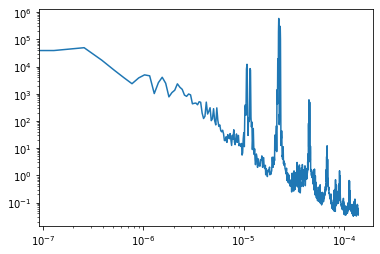

In [20]:
plt.loglog(Fllcw_H.freq_time, Fllcw_H.where(maskl).mean(['j','i'],skipna=True))

In [21]:
tmp_path = f'{SCRATCH}/region01/LLC4320/'+f'SSH_omega_fma.zarr'
print(tmp_path)
store_tmp = gcs.get_mapper(tmp_path)
dsave = Fllcw_H.where(maskl).mean(['j','i'], skipna=True).to_dataset(name='spectra')
dsave.spectra.encoding = {}
dsave.to_zarr(store_tmp, mode='w')
dsave.close()

gcs://meom-ige-scratch/roxyboy/region01/LLC4320/SSH_omega_fma.zarr


In [24]:
Fllcs_H = xrft.power_spectrum(Etas.chunk({'time':-1,'j':5,'i':5}).fillna(0.), 
                              dim=['time'], window='hann', detrend='linear', 
                              true_phase=True, true_amplitude=True,
                              window_correction=True
          )
Fllcs_H = Fllcs_H.isel(freq_time=slice(len(Fllcs_H.freq_time)//2,None)) * 2

Fllcs_H

<xarray.DataArray (freq_time: 1104, j: 46, i: 35)>
dask.array<mul, shape=(1104, 46, 35), dtype=float64, chunksize=(1104, 5, 5), chunktype=numpy.ndarray>
Coordinates:
  * freq_time  (freq_time) float64 0.0 1.258e-07 ... 0.0001386 0.0001388
Dimensions without coordinates: j, i

In [25]:
tmp_path = f'{SCRATCH}/region01/LLC4320/'+f'SSH_omega_aso.zarr'
print(tmp_path)
store_tmp = gcs.get_mapper(tmp_path)
dsave = Fllcs_H.where(maskl).mean(['j','i'], skipna=True).to_dataset(name='spectra')
dsave.spectra.encoding = {}
dsave.to_zarr(store_tmp, mode='w')
dsave.close()

gcs://meom-ige-scratch/roxyboy/region01/LLC4320/SSH_omega_aso.zarr


In [23]:
Fllcw_H = xr.open_zarr(gcs.get_mapper(f"gcs://meom-ige-scratch/roxyboy/region01/LLC4320/SSH_omega_fma.zarr")).spectra

Fllcs_H = xr.open_zarr(gcs.get_mapper(f"gcs://meom-ige-scratch/roxyboy/region01/LLC4320/SSH_omega_aso.zarr")).spectra

Fllcw_H

<xarray.DataArray 'spectra' (freq_time: 1080)>
dask.array<open_dataset-8748adf919c62553314c1b4eaaa2a66fspectra, shape=(1080,), dtype=float64, chunksize=(1080,), chunktype=numpy.ndarray>
Coordinates:
  * freq_time  (freq_time) float64 0.0 1.286e-07 ... 0.0001386 0.0001388

In [24]:
import gsw
f = gsw.f(enatl01w.nav_lat).mean(skipna=True).values
f

array(7.6885815e-05, dtype=float32)

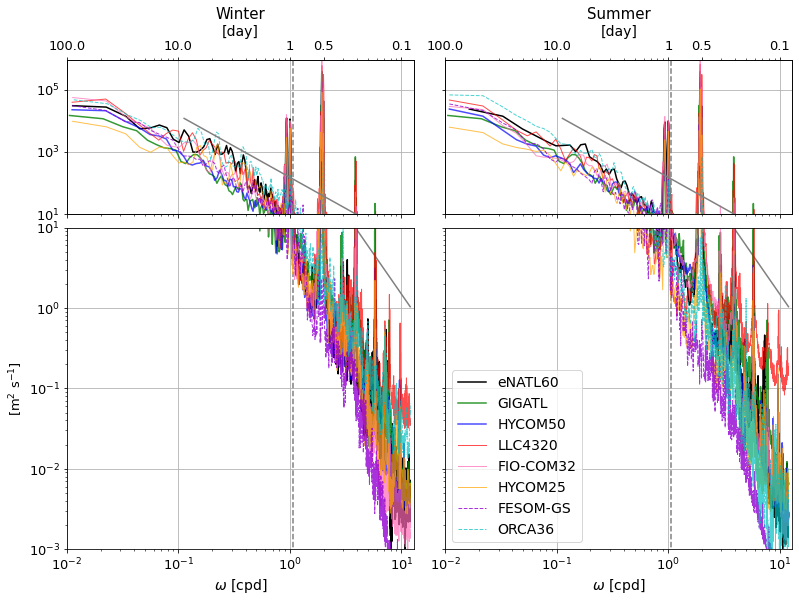

In [30]:
from matplotlib.gridspec import GridSpec

# fig, (ax1,ax2) = plt.subplots(figsize=(12,9), nrows=1, ncols=2)
# fig.set_tight_layout(True)
fig = plt.figure(figsize=(13,9))

gs = GridSpec(3, 2, figure=fig, wspace=.09, hspace=.09)
ax1 = fig.add_subplot(gs[0, 0])
# identical to ax1 = plt.subplot(gs.new_subplotspec((0, 0), colspan=3))
ax2 = fig.add_subplot(gs[1:, 0])
ax3 = fig.add_subplot(gs[0, 1])
ax4 = fig.add_subplot(gs[1:, 1])

ax5 = ax1.twiny()
ax6 = ax3.twiny()

ax6.plot(Fenatlw_H.freq_time[10:]*86400, Fenatlw_H.freq_time[10:]**-2*2e-8, c='grey', ls='-')
ax5.plot(Fenatlw_H.freq_time[10:]*86400, Fenatlw_H.freq_time[10:]**-2*2e-8, c='grey', ls='-')
ax4.plot(Fenatlw_H.freq_time[10:]*86400, Fenatlw_H.freq_time[10:]**-2*2e-8, c='grey', ls='-')
ax2.plot(Fenatlw_H.freq_time[10:]*86400, Fenatlw_H.freq_time[10:]**-2*2e-8, c='grey', ls='-')
ax2.plot(np.ones(2)*f/2/np.pi*86400, np.array([2e-4,9e5]), c='grey', ls='--')
ax4.plot(np.ones(2)*f/2/np.pi*86400, np.array([2e-4,9e5]), c='grey', ls='--')
ax5.plot(np.ones(2)*f/2/np.pi*86400, np.array([2e-4,9e5]), c='grey', ls='--')
ax6.plot(np.ones(2)*f/2/np.pi*86400, np.array([2e-4,9e5]), c='grey', ls='--')

ax3.plot(Fenatls_H.freq_time[1:]*86400, Fenatls_H[1:], 'k', label=r'')
ax1.plot(Fenatlw_H.freq_time[1:]*86400, Fenatlw_H[1:], 'k', label=r'')
ax3.plot(Fgigas_H.freq_time[1:]*86400, Fgigas_H[1:], 'g', alpha=.8, label=r'')
ax1.plot(Fgigaw_H.freq_time[1:]*86400, Fgigaw_H[1:], 'g', alpha=.8, label=r'')
ax3.plot(Fhycoms_H.freq_time[1:]*86400, Fhycoms_H[1:], 'b', alpha=.7, label=r'')
ax1.plot(Fhycomw_H.freq_time[1:]*86400, Fhycomw_H[1:], 'b', alpha=.7, label=r'')
ax3.plot(Fllcs_H.freq_time[1:]*86400, Fllcs_H[1:], c='r', alpha=.7, label=r'', lw=1)
ax1.plot(Fllcw_H.freq_time[1:]*86400, Fllcw_H[1:], c='r', alpha=.7, label=r'', lw=1)
ax3.plot(Ffios_H.freq_time[1:]*86400, Ffios_H[1:], c='hotpink', alpha=.7, label=r'', lw=1)
ax1.plot(Ffiow_H.freq_time[1:]*86400, Ffiow_H[1:], c='hotpink', alpha=.7, label=r'', lw=1)
ax3.plot(Fhycom25s_H.freq_time[1:]*86400, Fhycom25s_H[1:], c='orange', alpha=.7, label=r'', lw=1)
ax1.plot(Fhycom25w_H.freq_time[1:]*86400, Fhycom25w_H[1:], c='orange', alpha=.7, label=r'', lw=1)
ax3.plot(Ffesoms_H.freq_time[1:]*86400, Ffesoms_H[1:], c='darkviolet', ls='--', alpha=.8, label=r'', lw=1)
ax1.plot(Ffesomw_H.freq_time[1:]*86400, Ffesomw_H[1:], c='darkviolet', ls='--', alpha=.8, label=r'', lw=1)
ax3.plot(Forcas_H.freq_time[1:]*86400, Forcas_H[1:], 'c--', alpha=.7, label=r'', lw=1)
ax1.plot(Forcaw_H.freq_time[1:]*86400, Forcaw_H[1:], 'c--', alpha=.7, label=r'', lw=1)

ax4.plot(Fenatls_H.freq_time[1:]*86400, Fenatls_H[1:], 'k', label=r'eNATL60')
ax2.plot(Fenatlw_H.freq_time[1:]*86400, Fenatlw_H[1:], 'k', label=r'eNATL60')
ax4.plot(Fgigas_H.freq_time[1:]*86400, Fgigas_H[1:], 'g', alpha=.8, label=r'GIGATL')
ax2.plot(Fgigaw_H.freq_time[1:]*86400, Fgigaw_H[1:], 'g', alpha=.8, label=r'GIGATL')
ax4.plot(Fhycoms_H.freq_time[1:]*86400, Fhycoms_H[1:], 'b', alpha=.7, label=r'HYCOM50')
ax2.plot(Fhycomw_H.freq_time[1:]*86400, Fhycomw_H[1:], 'b', alpha=.7, label=r'HYCOM50')
ax4.plot(Fllcs_H.freq_time[1:]*86400, Fllcs_H[1:], c='r', alpha=.7, label=r'LLC4320', lw=1)
ax2.plot(Fllcw_H.freq_time[1:]*86400, Fllcw_H[1:], c='r', alpha=.7, label=r'LLC4320', lw=1)
ax4.plot(Ffios_H.freq_time[1:]*86400, Ffios_H[1:], c='hotpink', alpha=.7, label=r'FIO-COM32', lw=1)
ax2.plot(Ffiow_H.freq_time[1:]*86400, Ffiow_H[1:], c='hotpink', alpha=.7, label=r'FIO-COM32', lw=1)
ax4.plot(Fhycom25s_H.freq_time[1:]*86400, Fhycom25s_H[1:], c='orange', alpha=.7, label=r'HYCOM25', lw=1)
ax2.plot(Fhycom25w_H.freq_time[1:]*86400, Fhycom25w_H[1:], c='orange', alpha=.7, label=r'HYCOM25', lw=1)
ax4.plot(Ffesoms_H.freq_time[1:]*86400, Ffesoms_H[1:], c='darkviolet', ls='--', alpha=.8, label=r'FESOM-GS', lw=1)
ax2.plot(Ffesomw_H.freq_time[1:]*86400, Ffesomw_H[1:], c='darkviolet', ls='--', alpha=.8, label=r'FESOM-GS', lw=1)
ax4.plot(Forcas_H.freq_time[1:]*86400, Forcas_H[1:], 'c--', alpha=.7, label=r'ORCA36', lw=1)
ax2.plot(Forcaw_H.freq_time[1:]*86400, Forcaw_H[1:], 'c--', alpha=.7, label=r'ORCA36', lw=1)


ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlim([1e-2,13])
ax2.set_ylim([1e-3,1e1])
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_xlim([1e-2,13])
ax1.set_ylim([1e1,9e5])
ax3.set_xscale('log')
ax4.set_xscale('log')
ax3.set_yscale('log')
ax4.set_yscale('log')
ax3.set_xlim([1e-2,13])
ax4.set_xlim([1e-2,13])
ax4.set_ylim([1e-3,1e1])
ax3.set_ylim([1e1,9e5])
ax5.set_xscale('log')
ax6.set_xscale('log')
ax5.set_xlim([1e-2,13])
ax6.set_xlim([1e-2,13])

ax5.set_xticks([1e-2,1e-1,1,2,10])
ax6.set_xticks([1e-2,1e-1,1,2,10])
ax5.set_xticklabels([1e2,1e1,1,.5,.1])
ax6.set_xticklabels([1e2,1e1,1,.5,.1])
ax1.set_xticks([1e-2,1e-1,1,10])
ax3.set_xticks([1e-2,1e-1,1,10])
ax1.set_xticklabels([])
ax3.set_xticklabels([])

# ax1.tick_params(axis='x', labelsize=12)
ax1.tick_params(axis='y', labelsize=13)
ax2.tick_params(axis='x', labelsize=13)
ax2.tick_params(axis='y', labelsize=13)
ax3.tick_params(axis='x', labelsize=13)
ax3.tick_params(axis='y', labelsize=13)
ax4.tick_params(axis='x', labelsize=13)
ax4.tick_params(axis='y', labelsize=13)
ax3.axes.yaxis.set_ticklabels([])
ax4.axes.yaxis.set_ticklabels([])
ax5.tick_params(axis='x', labelsize=13)
ax6.tick_params(axis='x', labelsize=13)

ax4.legend(loc='lower left', fontsize=14)
ax4.set_xlabel(r"$\omega$ [cpd]", fontsize=14)
ax2.set_xlabel(r"$\omega$ [cpd]", fontsize=14)
ax5.set_xlabel(r"[day]", fontsize=14)
ax6.set_xlabel(r"[day]", fontsize=14)
ax2.set_ylabel(r"[m$^2$ s$^{-1}$]", fontsize=13)
ax1.set_title(r"Winter", fontsize=15)
ax3.set_title(r"Summer", fontsize=15)

ax1.grid(True)
ax2.grid(True)
ax3.grid(True)
ax4.grid(True)

plt.savefig('/home/jovyan/Figures/SSH_omega_01.pdf')

In [ ]:
client.close()